# Character-Level LSTM in PyTorch

In this notebook, I'll construct a character-level LSTM with PyTorch. The network will train character by character on some text, then generate new text character by character. As an example, I will train on Anna Karenina. **This model will be able to generate new text based on the text from the book!**

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn). Below is the general architecture of the character-wise RNN.

<img src="assets/charseq.jpeg" width="500">

First let's load in our required resources for data loading and model creation.

In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

## Load in Data

Then, we'll load the Anna Karenina text file and convert it into integers for our network to use. 

In [3]:
!wget https://github.com/udacity/deep-learning-v2-pytorch/raw/master/recurrent-neural-networks/char-rnn/data/anna.txt

--2020-02-02 21:52:29--  https://github.com/udacity/deep-learning-v2-pytorch/raw/master/recurrent-neural-networks/char-rnn/data/anna.txt
Resolving github.com (github.com)... 52.74.223.119
Connecting to github.com (github.com)|52.74.223.119|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/recurrent-neural-networks/char-rnn/data/anna.txt [following]
--2020-02-02 21:52:29--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/recurrent-neural-networks/char-rnn/data/anna.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2025486 (1.9M) [text/plain]
Saving to: ‘anna.txt’

anna.txt            100%[===================>]   1.93M  --.-KB/s    in 0

In [0]:
# open text file and read in data as `text`
with open('anna.txt', 'r') as f:
    text = f.read()

Let's check out the first 100 characters, make sure everything is peachy. According to the [American Book Review](http://americanbookreview.org/100bestlines.asp), this is the 6th best first line of a book ever.

In [5]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

### Tokenization

In the cells, below, I'm creating a couple **dictionaries** to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [6]:
# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])
max_enc = np.max(encoded)
print(max_enc)
print(f'Num characters: {len(text)}')

82
Num characters: 1985223


And we can see those same characters from above, encoded as integers.

In [7]:
encoded[:100]

array([10, 36, 70, 49, 43,  8, 13, 65, 17,  2,  2,  2, 68, 70, 49, 49, 46,
       65, 72, 70, 27, 60, 51, 60,  8, 38, 65, 70, 13,  8, 65, 70, 51, 51,
       65, 70, 51, 60, 44,  8, 53, 65,  8, 50,  8, 13, 46, 65, 14, 18, 36,
       70, 49, 49, 46, 65, 72, 70, 27, 60, 51, 46, 65, 60, 38, 65, 14, 18,
       36, 70, 49, 49, 46, 65, 60, 18, 65, 60, 43, 38, 65, 71,  3, 18,  2,
        3, 70, 46, 54,  2,  2, 63, 50,  8, 13, 46, 43, 36, 60, 18])

## Pre-processing the data

As you can see in our char-RNN image above, our LSTM expects an input that is **one-hot encoded** meaning that each character is converted into an integer (via our created dictionary) and *then* converted into a column vector where only it's corresponding integer index will have the value of 1 and the rest of the vector will be filled with 0's. Since we're one-hot encoding the data, let's make a function to do that!


In [0]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [9]:
# check that the function works as expected
test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


## Making training mini-batches


To train on this data, we also want to create mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>

In this example, we'll take the encoded characters (passed in as the `arr` parameter) and split them into multiple sequences, given by `batch_size`. Each of our sequences will be `seq_length` long.

### Creating Batches

**1. The first thing we need to do is discard some of the text so we only have completely full mini-batches. **

Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences in a batch) and $M$ is the seq_length or number of time steps in a sequence. Then, to get the total number of batches, $K$, that we can make from the array `arr`, you divide the length of `arr` by the number of characters per batch. Once you know the number of batches, you can get the total number of characters to keep from `arr`, $N * M * K$.

**2. After that, we need to split `arr` into $N$ batches. ** 

You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences in a batch, so let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$.

**3. Now that we have this array, we can iterate through it to get our mini-batches. **

The idea is each batch is a $N \times M$ window on the $N \times (M * K)$ array. For each subsequent batch, the window moves over by `seq_length`. We also want to create both the input and target arrays. Remember that the targets are just the inputs shifted over by one character. The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of tokens in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `seq_length` wide.

> **TODO:** Write the code for creating batches in the function below. The exercises in this notebook _will not be easy_. I've provided a notebook with solutions alongside this notebook. If you get stuck, checkout the solutions. The most important thing is that you don't copy and paste the code into here, **type out the solution code yourself.**

In [0]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    ## Entries in arr
    arr_size = len(arr)
    batch_length = batch_size*seq_length

    ## TODO: Get the number of batches we can make
    n_batches = arr_size // batch_length
    
    ## TODO: Keep only enough characters to make full batches
    trim = arr_size % batch_length
    arr  = arr[:arr_size-trim]
    
    ## TODO: Reshape into batch_size rows
    arr = arr.reshape((batch_size, n_batches*seq_length))
    
    ## TODO: Iterate over the batches using a window of size seq_length
    for n in range(0, n_batches):
        start = n*seq_length
        stop  = (n+1)*seq_length

        # The features
        x = arr[:, start:stop]
        # The targets, shifted by one
        if n < (n_batches-1):
          y = arr[:, start+1:stop+1]
        else:
          y = np.zeros(x.shape)
          y[:,:-1] = arr[:, start+1:stop]
          for i in range(len(y)-1):
            y[i,-1] = arr[i+1, 0]
          y[-1,-1] = arr[0,0]

        yield x, y

### Test Your Implementation

Now I'll make some data sets and we can check out what's going on as we batch data. Here, as an example, I'm going to use a batch size of 8 and 50 sequence steps.

In [0]:
batches = get_batches(encoded, 8, 50)
x, y = next(batches)

In [12]:
# printing out the first 10 items in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[10 36 70 49 43  8 13 65 17  2]
 [38 71 18 65 43 36 70 43 65 70]
 [ 8 18 15 65 71 13 65 70 65 72]
 [38 65 43 36  8 65  1 36 60  8]
 [65 38 70  3 65 36  8 13 65 43]
 [ 1 14 38 38 60 71 18 65 70 18]
 [65 29 18 18 70 65 36 70 15 65]
 [28 78 51 71 18 38 44 46 54 65]]

y
 [[36 70 49 43  8 13 65 17  2  2]
 [71 18 65 43 36 70 43 65 70 43]
 [18 15 65 71 13 65 70 65 72 71]
 [65 43 36  8 65  1 36 60  8 72]
 [38 70  3 65 36  8 13 65 43  8]
 [14 38 38 60 71 18 65 70 18 15]
 [29 18 18 70 65 36 70 15 65 38]
 [78 51 71 18 38 44 46 54 65 47]]


If you implemented `get_batches` correctly, the above output should look something like 
```
x
 [[25  8 60 11 45 27 28 73  1  2]
 [17  7 20 73 45  8 60 45 73 60]
 [27 20 80 73  7 28 73 60 73 65]
 [17 73 45  8 27 73 66  8 46 27]
 [73 17 60 12 73  8 27 28 73 45]
 [66 64 17 17 46  7 20 73 60 20]
 [73 76 20 20 60 73  8 60 80 73]
 [47 35 43  7 20 17 24 50 37 73]]

y
 [[ 8 60 11 45 27 28 73  1  2  2]
 [ 7 20 73 45  8 60 45 73 60 45]
 [20 80 73  7 28 73 60 73 65  7]
 [73 45  8 27 73 66  8 46 27 65]
 [17 60 12 73  8 27 28 73 45 27]
 [64 17 17 46  7 20 73 60 20 80]
 [76 20 20 60 73  8 60 80 73 17]
 [35 43  7 20 17 24 50 37 73 36]]
 ```
 although the exact numbers may be different. Check to make sure the data is shifted over one step for `y`.

---
## Defining the network with PyTorch

Below is where you'll define the network.

<img src="assets/charRNN.png" width=500px>

Next, you'll use PyTorch to define the architecture of the network. We start by defining the layers and operations we want. Then, define a method for the forward pass. You've also been given a method for predicting characters.

### Model Structure

In `__init__` the suggested structure is as follows:
* Create and store the necessary dictionaries (this has been done for you)
* Define an LSTM layer that takes as params: an input size (the number of characters), a hidden layer size `n_hidden`, a number of layers `n_layers`, a dropout probability `drop_prob`, and a batch_first boolean (True, since we are batching)
* Define a dropout layer with `drop_prob`
* Define a fully-connected layer with params: input size `n_hidden` and output size (the number of characters)
* Finally, initialize the weights (again, this has been given)

Note that some parameters have been named and given in the `__init__` function, and we use them and store them by doing something like `self.drop_prob = drop_prob`.

---
### LSTM Inputs/Outputs

You can create a basic [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) as follows

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. And we can add dropout by adding a dropout parameter with a specified probability; this will automatically add dropout to the inputs or outputs. Finally, in the `forward` function, we can stack up the LSTM cells into layers using `.view`. With this, you pass in a list of cells and it will send the output of one cell into the next cell.

We also need to create an initial hidden state of all zeros. This is done like so

```python
self.init_hidden()
```

In [13]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [0]:
import torch.nn.functional as F

class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars    = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        # Number of input/output characters
        n_chars = len(self.chars)

        # Define the layers of the model
        self.lstm = nn.LSTM(input_size=n_chars,
                            hidden_size=n_hidden,
                            num_layers=n_layers,
                            dropout=drop_prob,
                            batch_first=True)
        self.drop_prob = drop_prob
        self.fc = nn.Linear(n_hidden, n_chars)

        return
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''      
        # Get the outputs and the new hidden state from the lstm
        out, hidden = self.lstm(x)
        out = F.dropout(out, p=self.drop_prob)
        out = out.view(-1, self.n_hidden)
        out = self.fc(out)

        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

## Time to train

The train function gives us the ability to set the number of epochs, the learning rate, and other parameters.

Below we're using an Adam optimizer and cross entropy loss since we are looking at character class scores as output. We calculate the loss and perform backpropagation, as usual!

A couple of details about training: 
>* Within the batch loop, we detach the hidden state from its history; this time setting it equal to a new *tuple* variable because an LSTM has a hidden state that is a tuple of the hidden and cell states.
* We use [`clip_grad_norm_`](https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html) to help prevent exploding gradients.

In [0]:
import matplotlib.pyplot as plt
outfile = 'best_model.net'
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    min_loss = 1.0e6

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)

    # Training and test losses for plotting
    loss_trn = []
    loss_tst = []
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1

            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                loss_trn.append(loss.item())
                loss_tst.append(np.mean(val_losses))
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                # Save model if it is the best so far
                if (loss_tst[-1] < min_loss):
                    min_loss = loss_tst[-1]
                    torch.save(net.state_dict(), outfile)
                    print('   Saving model...')
                
    plt.plot(loss_trn, label='train loss')
    plt.plot(loss_tst, label='test loss')
    plt.legend();
    plt.show()

## Instantiating the model

Now we can actually train the network. First we'll create the network itself, with some given hyperparameters. Then, define the mini-batches sizes, and start training!

In [16]:
## TODO: set your model hyperparameters
# define and print the net
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, drop_prob=0.5)
print(net)

CharRNN(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


### Set your training hyperparameters!

Epoch: 1/60... Step: 10... Loss: 3.1808... Val Loss: 3.1651
   Saving model...
Epoch: 2/60... Step: 20... Loss: 3.1487... Val Loss: 3.1363
   Saving model...
Epoch: 3/60... Step: 30... Loss: 3.1225... Val Loss: 3.1174
   Saving model...
Epoch: 4/60... Step: 40... Loss: 3.1212... Val Loss: 3.1131
   Saving model...
Epoch: 4/60... Step: 50... Loss: 3.1176... Val Loss: 3.1081
   Saving model...
Epoch: 5/60... Step: 60... Loss: 3.1171... Val Loss: 3.1026
   Saving model...
Epoch: 6/60... Step: 70... Loss: 3.1037... Val Loss: 3.0947
   Saving model...
Epoch: 7/60... Step: 80... Loss: 3.0890... Val Loss: 3.0830
   Saving model...
Epoch: 7/60... Step: 90... Loss: 3.0761... Val Loss: 3.0570
   Saving model...
Epoch: 8/60... Step: 100... Loss: 3.0210... Val Loss: 2.9953
   Saving model...
Epoch: 9/60... Step: 110... Loss: 2.9348... Val Loss: 2.8902
   Saving model...
Epoch: 10/60... Step: 120... Loss: 2.8321... Val Loss: 2.7983
   Saving model...
Epoch: 10/60... Step: 130... Loss: 2.7375... Val

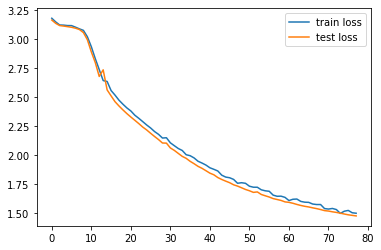

In [17]:
batch_size = 128
seq_length = 1000
n_epochs   = 60 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.002, print_every=10)

## Getting the best model

To set your hyperparameters to get the best performance, you'll want to watch the training and validation losses. If your training loss is much lower than the validation loss, you're overfitting. Increase regularization (more dropout) or use a smaller network. If the training and validation losses are close, you're underfitting so you can increase the size of the network.

## Hyperparameters

Here are the hyperparameters for the network.

In defining the model:
* `n_hidden` - The number of units in the hidden layers.
* `n_layers` - Number of hidden LSTM layers to use.

We assume that dropout probability and learning rate will be kept at the default, in this example.

And in training:
* `batch_size` - Number of sequences running through the network in one pass.
* `seq_length` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lr` - Learning rate for training

Here's some good advice from Andrej Karpathy on training the network. I'm going to copy it in here for your benefit, but also link to [where it originally came from](https://github.com/karpathy/char-rnn#tips-and-tricks).

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `n_hidden` and `n_layers`. I would advise that you always use `n_layers` of either 2/3. The `n_hidden` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `n_hidden` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

## Checkpoint

After training, we'll save the model so we can load it again later if we need too. Here I'm saving the parameters needed to create the same architecture, the hidden layer hyperparameters and the text characters.

In [18]:
# change the name, for saving multiple files
model_name = 'rnn_x_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

# Load the best model
net.load_state_dict(torch.load(outfile))

<All keys matched successfully>

---
## Making Predictions

Now that the model is trained, we'll want to sample from it and make predictions about next characters! To sample, we pass in a character and have the network predict the next character. Then we take that character, pass it back in, and get another predicted character. Just keep doing this and you'll generate a bunch of text!

### A note on the `predict`  function

The output of our RNN is from a fully-connected layer and it outputs a **distribution of next-character scores**.

> To actually get the next character, we apply a softmax function, which gives us a *probability* distribution that we can then sample to predict the next character.

### Top K sampling

Our predictions come from a categorical probability distribution over all the possible characters. We can make the sample text and make it more reasonable to handle (with less variables) by only considering some $K$ most probable characters. This will prevent the network from giving us completely absurd characters while allowing it to introduce some noise and randomness into the sampled text. Read more about [topk, here](https://pytorch.org/docs/stable/torch.html#torch.topk).


In [0]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

### Priming and generating text 

Typically you'll want to prime the network so you can build up a hidden state. Otherwise the network will start out generating characters at random. In general the first bunch of characters will be a little rough since it hasn't built up a long history of characters to predict from.

In [0]:
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [21]:
print(sample(net, 1000, prime='Anna', top_k=5))

Annanenide anesedind anothed arigrins on alenge thisithin in tene the o oused thisthithilis te his tithest he s mata thaneled wa t thiraren wes ase no we then aratimestined.. asin he stre we st tes athothinthad ton henga ha thedines
he hily o as harene wist hingis ath oniten whasa onin
m th he
he hheste
thatinge ale horas were onenes tatousheshovorarouly hid than titarathallely arededrotino hed
the onirreres wasin'serinitheden thitin se whelalithe t tasen h he hanathens honglis thed
n tonese tinanen hen. ted honins hed
hed te winen'lelounind hed
as sastinitily wh the was an aditouserotitare onsese
ange aly chesithedit then ha ouronelerinsthanasatin hinste onons ofurithitethot winis te wesinhed.
co aninederane oringined allangas t t n thensigenthest has has ho han a o thero te h the he ate hitheronothen ines t hote ithen onn hele then he t taling wen wed he thesidest arinonesase herite he tes hathiknongan s t at hed stithinan tit hit asesasenoure ad woninedinovedesid aruted titonine wad

## Loading a checkpoint

In [22]:
# Here we have loaded in a model that trained over 20 epochs `rnn_20_epoch.net`
with open('rnn_x_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

# Load the actual best fit network
loaded.load_state_dict(torch.load(outfile))

<All keys matched successfully>

In [23]:
# Sample using a loaded model
print(sample(loaded, 2000, top_k=5, prime="And Levin said"))

And Levin saiderinorarin teve anane the hid wan henist heded a ounente ilin a he a wes athe tite hedan o h orinenen tan thelat whimat ouningrid hengre anengen ath tide hededire asheranouse
hillisis
touliner asinthe on
a t the a we hathen tenithed alineshesh t oneded
lid
outine wa ade wen athed hothe ininitone tha wan aranshe tidres in a hore he
atin wouse hanenere
ithen hede
nsilonoraloneronouthe wanenidon o t talede
we
he
ste
sane ore ns hedised hete ha she o o
t anen tedis in ite te waneshin we we whoriland
thinontareshathed s watithas ishonininnthe hone hougathe we a o hent a a adis hens a ared onthoury."
st arenone
honar t hat
tiratred se
st hon athise oun h h tharere s t inesitinthesinnondinghes a onire hono
one tin he ofitises herared
s wed he henede
hinevistothes cis hese athinourery had. t the oule oniratonshend t the a he
hes o he thiren ouran tit th tatiliteshe oren the thed uton
lishe on want hredrenin t sin then hesthitheneralile adan hre t whest ot ons hitatediderounene sa